In [64]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set_style("darkgrid")
from sklearn import linear_model
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
import random

import warnings
warnings.filterwarnings('ignore')

#Auxiliares

def far_to_cel(temp):
    return 5*(temp)/9 - 5*32/9


#Función para sacar outliers
#(se puede cambiar eso de s-s.mean <= etc, esa es una forma posible de detectar outliers)

def mascara_outliers(s, mult):
    return abs(s - s.mean()) <= mult*s.std()

def sacar_outliers(datos,tag,mult):
    mascara = mascara_outliers(datos[tag], mult)
    return datos[mascara]


#Función para delimitar ejes:
#(dice dominio, pero se puede usar para imagen también... ya se que esta medio cabeza, pero anda bien)

def mascara_dominio_abajo(s,x0):
    return x0 <= s
def mascara_dominio_arriba(s,x1):
    return s <= x1

def achicar_dominio(datos,tag,x0,x1):
    mascara = mascara_dominio_abajo(datos[tag],x0)
    datos = datos[mascara]
    mascara = mascara_dominio_arriba(datos[tag],x1)
    return datos[mascara]


#Función para crear una columna con cada año
#(es imrpotante haber cargado el csv con el arguemtno parse_dates=[tag])
def crear_col_años(datos,tag):
    return datos[tag].apply (lambda x : x.year if x.month < 12 else x.year + 1)

In [83]:
################################
# Levanto los datos, y los veo #
################################

df = pd.read_csv('../data/temperaturas_catedra/GlobalLandTemperaturesByCountry.csv', parse_dates=['dt'])
df_lat_long = pd.read_csv('../data/polos/sea_level/La_Corunia.csv')

df_south_pole = pd.read_csv('../data/polos/temperaturas/south_pole.csv')


df_greenland = df[df['Country'] == 'Greenland'].reset_index()
df_greenland['year'] = crear_col_años(df_greenland, "dt")
df_greenland = df_greenland.groupby(['year']).mean().reset_index()


df_sl_global = pd.read_csv('../data/polos/sea_level/global.csv')


#print("Decripción de los datos")
#print(df_greenland.describe())


######################
# Gráficos los datos #
######################

#Para el polo sur

#convirtiendo todo a celsius
for i in range(0,41):
    df_south_pole.ix[i, 'temp'] = far_to_cel(df_south_pole.ix[i, 'temp'])
    #print(df_south_pole.ix[i, 'temp'])
    
df_south_pole = sacar_outliers(df_south_pole, 'temp', 1)
    
ax = sns.tsplot(data=df_south_pole['temp'], time=df_south_pole['year'], interpolate=False)
sns.plt.xlim((1955,2000))
sns.plt.show()
sns.plt.close()

#Para Groenlandia

df_greenland = sacar_outliers(df_greenland, 'AverageTemperature', 1)

ax = sns.tsplot(data=df_greenland['AverageTemperature'], time=df_greenland['year'], interpolate=False)
sns.plt.xlim((1955,2004))
sns.plt.show()
sns.plt.close()


#Para el nivel del mar global

df_sl_global = achicar_dominio(df_sl_global,'Year',1955,2000)

ax = sns.tsplot(data=df_sl_global['CSIRO Adjusted Sea Level'], time=df_sl_global['Year'], interpolate=False)
sns.plt.xlim((1950,2010))
sns.plt.show()
sns.plt.close()

# Ahora si, lo importante del TP

Error de predicción: 1.04


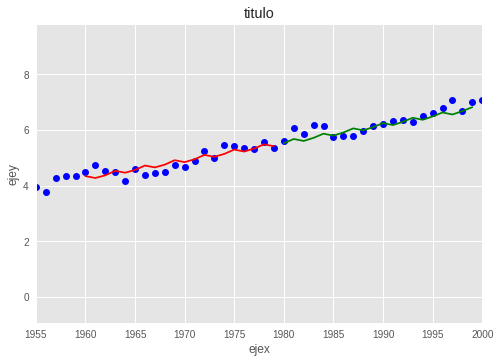

In [80]:
# Uso cuadrados mínimos para predecir


def armar_matriz_A(s):
    temp = []
    for t in s:
        #temp.append([t^4, t^3, t^2, t, 1, np.sin(t)])
        temp.append([t, 1, np.cos((2.1)*t+6)])
    return np.array(temp)

def entrenar_y_predecir_en_rangos(df, rango_entrenamiento, rango_prediccion, tag1, tag2):
    regr = linear_model.LinearRegression(fit_intercept=False)

    # Entreno el modelo
    df_e = df[df[tag1].isin(rango_entrenamiento)]
    A_e = armar_matriz_A(df_e[tag1])
    regr.fit(A_e, df_e[tag2])

    # Me fijo la aproximación que se realizó
    df_e['p'] = regr.predict(A_e)
    sns.tsplot(time=df_e[tag1], data=df_e['p'], color='r')

    # Realizo predicciones
    df_p = df[df[tag1].isin(rango_prediccion)]

    A_p = armar_matriz_A(df_p[tag1])
    df_p['p'] = regr.predict(A_p)
    sns.tsplot(time=df_p[tag1], data=df_p['p'], color='g')

    ECM = sum((df_p['p']-df_p[tag2])**2)
    return ECM

def predecir(datos, k, rango,limitador, tag1, tag2):
    return entrenar_y_predecir_en_rangos(datos, range(k-rango,k), range(k,k+rango-limitador), tag1, tag2)


def graficador(datos, año, rango, limitador, x0, x1):
    ECM = predecir(datos,año,rango,limitador,'Year', 'CSIRO Adjusted Sea Level')
    print("Error de predicción: {:.2f}".format(ECM))
        
    sns.plt.xlim((x0,x1))
    sns.plt.title('titulo')
    sns.plt.xlabel('ejex')
    sns.plt.ylabel('ejey')
    sns.plt.show()
    sns.plt.close()


sns.tsplot(data=df_sl_global['CSIRO Adjusted Sea Level'], time=df_sl_global['Year'], interpolate=False, color='b')
graficador(df_sl_global, 1980, 20, 0, 1955, 2000)
